In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import importlib
import utilities
import config as cfg
import logging
import models.lstm_dropout_dense_droput as stockPredictorModule
import importlib
from keras.utils.vis_utils import plot_model

# build and pre process the dataset
## data in the dataset
all the financial data from 2011 until 2021
<br>
the data is taken from the Sharadar database at quandl so you will need an API Key to access it.
## dataset for training
each input for the lstm consists of 5 data points that have a 5 year finanacial data.
the label is the change in precentage between the price on year 7 and year 5.
this is a moving time window meaning that for 10 years of data each company will have 5 inputs as follows:
       

|                        Features                     |                 label                    |
| :-------------------------------------------------: | :--------------------------------------: |
| year_2011 year_2012 year_2013 year_2014 year_2015   |   year_2017[price] / year_2015[price]    |
| year_2012 year_2013 year_2014 year_2015 year_2016   |   year_2018[price] / year_2016[price]    |
| year_2013 year_2014 year_2015 year_2016 year_2017   |   year_2019[price] / year_2017[price]    |
| year_2014 year_2015 year_2016 year_2017 year_2018   |   year_2020[price] / year_2018[price]    |
| year_2015 year_2016 year_2017 year_2018 year_2019   |   year_2021[price] / year_2019[price]    |

## preprocessing the dataset
1. for the preprocessing stage we remove the columns that have a lot of null values.
2. drop rows that still have null values after removing the columns.
3. load and add the meta data of a stock like the sector or the industry, those are all categorical type data.
4. we turn the categorical data into dummy columns while grouping rare categories as 'other' category.
   each dummy column has the original column as a prefix
5. we build the X and y as a time window as described above.
6. seperate to train, val, test split.

In [3]:
start_year = '2010-12-31'
end_year = '2019-12-31'
min_date = '2009-12-31'
max_date = '2020-12-31'

df = utilities.load_data('<Your Quandl API Key>')
df = df[(df['calendardate'] >= start_year) & (df['calendardate'] <= end_year)]

df = utilities.handle_null_values(df, limit_null_percent = 0.01, drop_null_rows = True)
df = utilities.drop_columns_with_one_dominant_value(df, one_value_threshold = 0.8)

meta_df = utilities.load_meta_data('<Your Quandl API Key>')
meta_columns_to_use = ['exchange', 'category', 'sicsector', 'sicindustry', 'sector', 'industry', 'scalemarketcap', 'scalerevenue', 'currency']
df, dummy_columns_indeces = utilities.add_meta_data(df, meta_df, meta_columns = meta_columns_to_use, rare_threshold = 0.1)

X, y = utilities.build_features_labels_windows(df, min_date = min_date, max_date = max_date, years_interval = 5, leap_interval = 2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.11)

In [4]:
display(utilities.count_categories(y_val))
display(utilities.count_categories(y_test))
display(utilities.count_categories(y_train))

count of category [0,0,0,0,1] is: 90
count of category [0,0,0,1,0] is: 152
count of category [0,0,1,0,0] is: 474
count of category [0,1,0,0,0] is: 418
count of category [1,0,0,0,0] is: 203


None

count of category [0,0,0,0,1] is: 101
count of category [0,0,0,1,0] is: 136
count of category [0,0,1,0,0] is: 455
count of category [0,1,0,0,0] is: 467
count of category [1,0,0,0,0] is: 191


None

count of category [0,0,0,0,1] is: 682
count of category [0,0,0,1,0] is: 1193
count of category [0,0,1,0,0] is: 3901
count of category [0,1,0,0,0] is: 3518
count of category [1,0,0,0,0] is: 1518


None

# Experiment 1
lstm layer size - 256
<br>
dense layer size - 256
<br>
activation function - tanh
<br>
optimizer - adam with 0.01 learning rate
<br>
loss - CategoricalCrossEntropy
<br>
acurracy - Categorical Accuracy

In [5]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, "tanh", "tanh")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               376832    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = stock_price_predictior.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))

Epoch 1/500
338/338 [==============================] - 6s 12ms/step - loss: 1.3883 - categorical_accuracy: 0.3931 - val_loss: 1.3549 - val_categorical_accuracy: 0.4069
Epoch 2/500
338/338 [==============================] - 4s 10ms/step - loss: 1.3392 - categorical_accuracy: 0.4123 - val_loss: 1.3598 - val_categorical_accuracy: 0.4061
Epoch 3/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3247 - categorical_accuracy: 0.4167 - val_loss: 1.3406 - val_categorical_accuracy: 0.4211
Epoch 4/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3156 - categorical_accuracy: 0.4280 - val_loss: 1.3391 - val_categorical_accuracy: 0.4226
Epoch 5/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3029 - categorical_accuracy: 0.4327 - val_loss: 1.3417 - val_categorical_accuracy: 0.4293
Epoch 6/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3006 - categorical_accuracy: 0.4362 - val_loss: 1.3446 - val_categorical_accuracy:

338/338 [==============================] - 4s 10ms/step - loss: 0.8866 - categorical_accuracy: 0.6332 - val_loss: 1.5567 - val_categorical_accuracy: 0.4174
Epoch 98/500
338/338 [==============================] - 3s 10ms/step - loss: 0.8800 - categorical_accuracy: 0.6338 - val_loss: 1.5550 - val_categorical_accuracy: 0.4151
Epoch 99/500
338/338 [==============================] - 3s 10ms/step - loss: 0.8768 - categorical_accuracy: 0.6398 - val_loss: 1.5712 - val_categorical_accuracy: 0.4211
Epoch 100/500
338/338 [==============================] - 3s 10ms/step - loss: 0.8718 - categorical_accuracy: 0.6402 - val_loss: 1.5858 - val_categorical_accuracy: 0.4061
Epoch 101/500
338/338 [==============================] - 3s 10ms/step - loss: 0.8569 - categorical_accuracy: 0.6462 - val_loss: 1.6055 - val_categorical_accuracy: 0.4031
Epoch 102/500
338/338 [==============================] - 3s 10ms/step - loss: 0.8698 - categorical_accuracy: 0.6393 - val_loss: 1.5614 - val_categorical_accuracy: 0.4

338/338 [==============================] - 4s 10ms/step - loss: 0.7540 - categorical_accuracy: 0.6977 - val_loss: 1.6924 - val_categorical_accuracy: 0.4106
Epoch 194/500
338/338 [==============================] - 4s 11ms/step - loss: 0.7639 - categorical_accuracy: 0.6876 - val_loss: 1.7432 - val_categorical_accuracy: 0.4084
Epoch 195/500
338/338 [==============================] - 4s 10ms/step - loss: 0.7700 - categorical_accuracy: 0.6854 - val_loss: 1.7132 - val_categorical_accuracy: 0.4114
Epoch 196/500
338/338 [==============================] - 4s 11ms/step - loss: 0.7683 - categorical_accuracy: 0.6915 - val_loss: 1.7081 - val_categorical_accuracy: 0.4061
Epoch 197/500
338/338 [==============================] - 4s 11ms/step - loss: 0.7650 - categorical_accuracy: 0.6903 - val_loss: 1.7085 - val_categorical_accuracy: 0.4084
Epoch 198/500
338/338 [==============================] - 4s 11ms/step - loss: 0.7490 - categorical_accuracy: 0.6936 - val_loss: 1.7363 - val_categorical_accuracy: 0

KeyboardInterrupt: 

In [7]:
evaluation_train = stock_price_predictior.evaluate(np.array(X_train), np.array(y_train))
evaluation_val = stock_price_predictior.evaluate(np.array(X_val), np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(np.array(X_test), np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 3ms/step - loss: 1.8094 - categorical_accuracy: 0.3919

loss on training set: 0.41071948409080505
accuracy on training set: 0.877265989780426

loss on validation set: 1.7249211072921753
accuracy on validation set: 0.40613314509391785

loss on test set: 1.809404969215393
accuracy on test set: 0.39185184240341187


## creating a new model with the same parameter and adding an early stopping callback

In [9]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, "tanh", "tanh")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = stock_price_predictior.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), add_early_stopping = True)

Epoch 1/500
338/338 [==============================] - 6s 11ms/step - loss: 1.3999 - categorical_accuracy: 0.3915 - val_loss: 1.3698 - val_categorical_accuracy: 0.3874
Epoch 2/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3413 - categorical_accuracy: 0.4124 - val_loss: 1.3605 - val_categorical_accuracy: 0.3927
Epoch 3/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3247 - categorical_accuracy: 0.4209 - val_loss: 1.3480 - val_categorical_accuracy: 0.4174
Epoch 4/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3239 - categorical_accuracy: 0.4177 - val_loss: 1.3522 - val_categorical_accuracy: 0.4188
Epoch 5/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3118 - categorical_accuracy: 0.4230 - val_loss: 1.3395 - val_categorical_accuracy: 0.4271
Epoch 6/500
338/338 [==============================] - 3s 10ms/step - loss: 1.3080 - categorical_accuracy: 0.4304 - val_loss: 1.3443 - val_categorical_accuracy:

In [11]:
evaluation_train = stock_price_predictior.evaluate(np.array(X_train), np.array(y_train))
evaluation_val = stock_price_predictior.evaluate(np.array(X_val), np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(np.array(X_test), np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 3ms/step - loss: 1.3614 - categorical_accuracy: 0.4089

loss on training set: 1.2498652935028076
accuracy on training set: 0.45856454968452454

loss on validation set: 1.340843915939331
accuracy on validation set: 0.4300673007965088

loss on test set: 1.3613758087158203
accuracy on test set: 0.40888887643814087


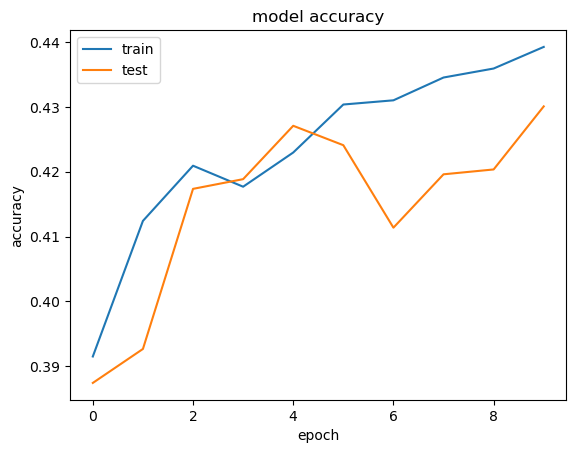

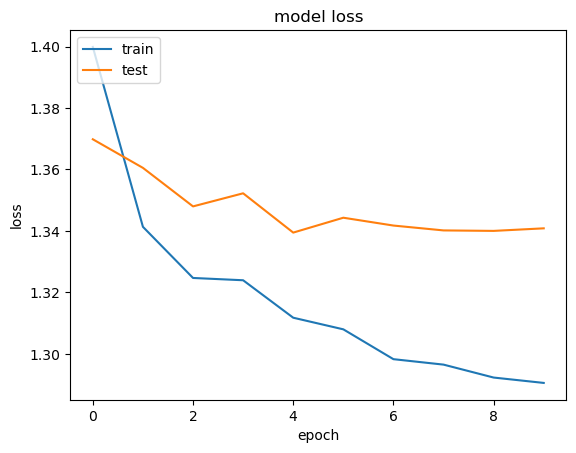

In [12]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## agument the data and run again with the same model

In [13]:
indeces = utilities.get_category_indeces(y)
print(len(indeces[1]))
print(len(indeces[10]))
print(len(indeces[100]))
print(len(indeces[1000]))
print(len(indeces[10000]))

1912
4403
4830
1481
873


In [14]:
importlib.reload(utilities)
X_train_new, y_train_new = utilities.train_data_augmentation(X_train, y_train, 7000, dummy_columns_indeces)
utilities.count_categories(y_train_new)

count of category [0,0,0,0,1] is: 7000
count of category [0,0,0,1,0] is: 7000
count of category [0,0,1,0,0] is: 7000
count of category [0,1,0,0,0] is: 7000
count of category [1,0,0,0,0] is: 7000


In [15]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, "tanh", "tanh")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = stock_price_predictior.fit(np.array(X_train_new), np.array(y_train_new), np.array(X_val), np.array(y_val), add_early_stopping = True)

Epoch 1/500
1094/1094 [==============================] - 13s 11ms/step - loss: 1.4891 - categorical_accuracy: 0.3394 - val_loss: 1.5126 - val_categorical_accuracy: 0.2962
Epoch 2/500
1094/1094 [==============================] - 11s 10ms/step - loss: 1.4342 - categorical_accuracy: 0.3729 - val_loss: 1.5160 - val_categorical_accuracy: 0.2872
Epoch 3/500
1094/1094 [==============================] - 11s 10ms/step - loss: 1.4009 - categorical_accuracy: 0.3927 - val_loss: 1.5174 - val_categorical_accuracy: 0.2999
Epoch 4/500
1094/1094 [==============================] - 11s 10ms/step - loss: 1.3656 - categorical_accuracy: 0.4052 - val_loss: 1.4915 - val_categorical_accuracy: 0.3313
Epoch 5/500
1094/1094 [==============================] - 11s 10ms/step - loss: 1.3158 - categorical_accuracy: 0.4379 - val_loss: 1.5477 - val_categorical_accuracy: 0.2872
Epoch 6/500
1094/1094 [==============================] - 11s 10ms/step - loss: 1.2708 - categorical_accuracy: 0.4615 - val_loss: 1.5194 - val_cat

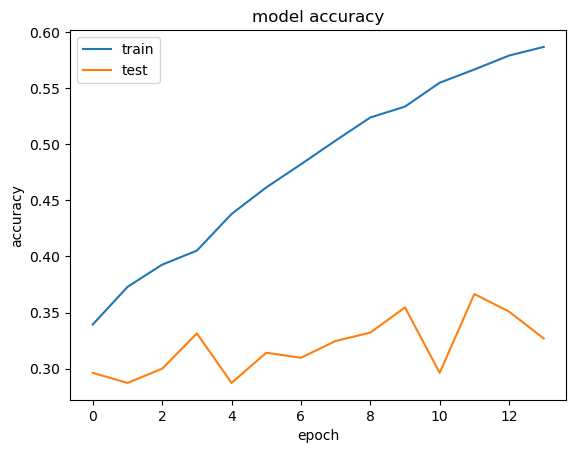

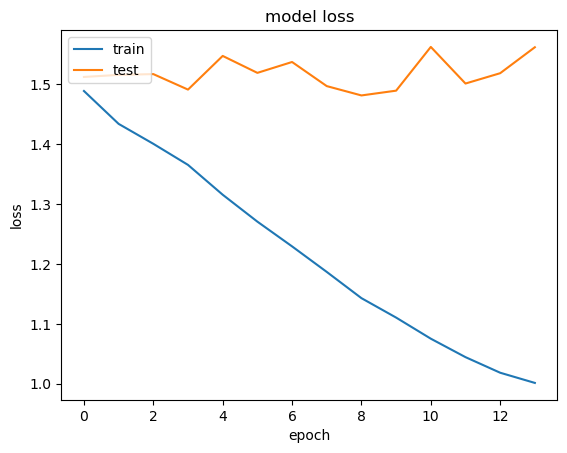

In [17]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
evaluation_train = stock_price_predictior.evaluate(np.array(X_train), np.array(y_train))
evaluation_train_aug = stock_price_predictior.evaluate(np.array(X_train_new), np.array(y_train_new))
evaluation_val = stock_price_predictior.evaluate(np.array(X_val), np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(np.array(X_test), np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val, evaluation_train_aug)

43/43 [==============================] - 0s 4ms/step - loss: 1.5965 - categorical_accuracy: 0.3437

loss on training set: 1.0107661485671997
accuracy on training set: 0.5630780458450317

loss on augmented training set: 0.8003263473510742
accuracy on augmented training set: 0.6904857158660889

loss on validation set: 1.562255859375
accuracy on validation set: 0.32685115933418274

loss on test set: 1.5965360403060913
accuracy on test set: 0.3437037169933319


# Experiment 2
lstm layer size - 128
<br>
dense layer size - 128
<br>
activation function - tanh
<br>
optimizer - adam with 0.01 learning rate
<br>
loss - CategoricalCrossEntropy
<br>
acurracy - Categorical Accuracy

In [19]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 128, 128, "tanh", "tanh")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               122880    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 140,037
Trainable params: 140,037
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = stock_price_predictior.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), add_early_stopping = True)

Epoch 1/500
338/338 [==============================] - 4s 5ms/step - loss: 1.3916 - categorical_accuracy: 0.3880 - val_loss: 1.3569 - val_categorical_accuracy: 0.4121
Epoch 2/500
338/338 [==============================] - 1s 4ms/step - loss: 1.3497 - categorical_accuracy: 0.4059 - val_loss: 1.3482 - val_categorical_accuracy: 0.4233
Epoch 3/500
338/338 [==============================] - 1s 4ms/step - loss: 1.3448 - categorical_accuracy: 0.4068 - val_loss: 1.3639 - val_categorical_accuracy: 0.3874
Epoch 4/500
338/338 [==============================] - 1s 4ms/step - loss: 1.3425 - categorical_accuracy: 0.4123 - val_loss: 1.3547 - val_categorical_accuracy: 0.4129
Epoch 5/500
338/338 [==============================] - 1s 4ms/step - loss: 1.3383 - categorical_accuracy: 0.4080 - val_loss: 1.3635 - val_categorical_accuracy: 0.4031
Epoch 6/500
338/338 [==============================] - 1s 4ms/step - loss: 1.3316 - categorical_accuracy: 0.4133 - val_loss: 1.3480 - val_categorical_accuracy: 0.409

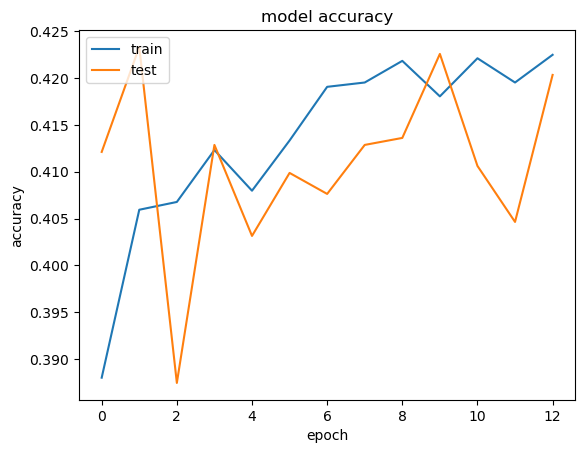

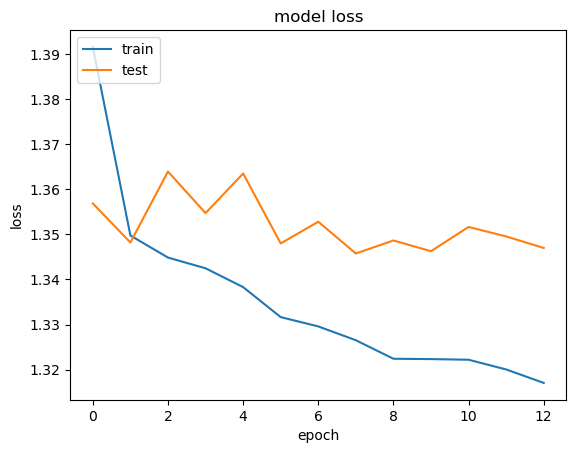

In [21]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
evaluation_train = stock_price_predictior.evaluate(np.array(X_train), np.array(y_train))
evaluation_val = stock_price_predictior.evaluate(np.array(X_val), np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(np.array(X_test), np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 2ms/step - loss: 1.3677 - categorical_accuracy: 0.3881

loss on training set: 1.2974621057510376
accuracy on training set: 0.42406585812568665

loss on validation set: 1.3469828367233276
accuracy on validation set: 0.4203440546989441

loss on test set: 1.367745041847229
accuracy on test set: 0.38814815878868103


In [23]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 128, 128, "tanh", "tanh")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               122880    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 140,037
Trainable params: 140,037
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = stock_price_predictior.fit(np.array(X_train_new), np.array(y_train_new), np.array(X_val), np.array(y_val), add_early_stopping = True)

Epoch 1/500
1094/1094 [==============================] - 6s 4ms/step - loss: 1.5101 - categorical_accuracy: 0.3206 - val_loss: 1.4927 - val_categorical_accuracy: 0.3164
Epoch 2/500
1094/1094 [==============================] - 4s 4ms/step - loss: 1.4794 - categorical_accuracy: 0.3407 - val_loss: 1.4678 - val_categorical_accuracy: 0.3074
Epoch 3/500
1094/1094 [==============================] - 4s 4ms/step - loss: 1.4667 - categorical_accuracy: 0.3468 - val_loss: 1.4887 - val_categorical_accuracy: 0.3246
Epoch 4/500
1094/1094 [==============================] - 4s 4ms/step - loss: 1.4503 - categorical_accuracy: 0.3565 - val_loss: 1.5248 - val_categorical_accuracy: 0.2760
Epoch 5/500
1094/1094 [==============================] - 4s 4ms/step - loss: 1.4376 - categorical_accuracy: 0.3659 - val_loss: 1.4817 - val_categorical_accuracy: 0.3216
Epoch 6/500
1094/1094 [==============================] - 4s 4ms/step - loss: 1.4253 - categorical_accuracy: 0.3737 - val_loss: 1.5021 - val_categorical_acc

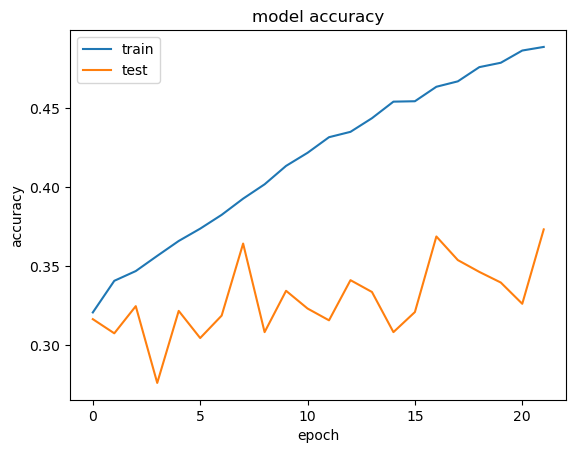

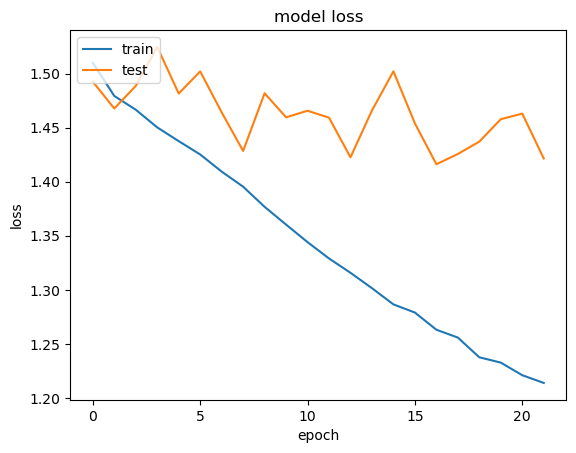

In [25]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
evaluation_train = stock_price_predictior.evaluate(np.array(X_train), np.array(y_train))
evaluation_train_aug = stock_price_predictior.evaluate(np.array(X_train_new), np.array(y_train_new))
evaluation_val = stock_price_predictior.evaluate(np.array(X_val), np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(np.array(X_test), np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val, evaluation_train_aug)

43/43 [==============================] - 0s 2ms/step - loss: 1.4817 - categorical_accuracy: 0.3548

loss on training set: 1.1893727779388428
accuracy on training set: 0.4695708453655243

loss on augmented training set: 1.0545456409454346
accuracy on augmented training set: 0.5719143152236938

loss on validation set: 1.4215527772903442
accuracy on validation set: 0.3732236325740814

loss on test set: 1.4817472696304321
accuracy on test set: 0.3548148274421692


# Experiment 3
lstm layer size - 256
<br>
dense layer size - 256
<br>
activation function - relu
<br>
optimizer - adam with 0.01 learning rate
<br>
loss - CategoricalCrossEntropy
<br>
acurracy - Categorical Accuracy

In [27]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, 'relu', 'relu')
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


### before we can use the relu activation we will want to scale the data

In [28]:
scaler = utilities.StandardScaler3D()
X_train_scaled = scaler.fit_transform(np.array(X_train))
X_val_scaled = utilities.apply3DScaler(np.array(X_val), scaler)
X_test_scaled = utilities.apply3DScaler(np.array(X_test), scaler)

In [29]:
history = stock_price_predictior.fit(X_train_scaled, np.array(y_train), X_val_scaled, np.array(y_val), add_early_stopping = True)

Epoch 1/500
338/338 [==============================] - 6s 13ms/step - loss: 1.3860 - categorical_accuracy: 0.3984 - val_loss: 1.3896 - val_categorical_accuracy: 0.3904
Epoch 2/500
338/338 [==============================] - 4s 12ms/step - loss: 1.3422 - categorical_accuracy: 0.4169 - val_loss: 1.3419 - val_categorical_accuracy: 0.3882
Epoch 3/500
338/338 [==============================] - 4s 12ms/step - loss: 1.3124 - categorical_accuracy: 0.4240 - val_loss: 1.3397 - val_categorical_accuracy: 0.4174
Epoch 4/500
338/338 [==============================] - 4s 12ms/step - loss: 1.2855 - categorical_accuracy: 0.4356 - val_loss: 1.3400 - val_categorical_accuracy: 0.4151
Epoch 5/500
338/338 [==============================] - 4s 12ms/step - loss: 1.2718 - categorical_accuracy: 0.4434 - val_loss: 1.3396 - val_categorical_accuracy: 0.4181
Epoch 6/500
338/338 [==============================] - 4s 12ms/step - loss: 1.2612 - categorical_accuracy: 0.4517 - val_loss: 1.3499 - val_categorical_accuracy:

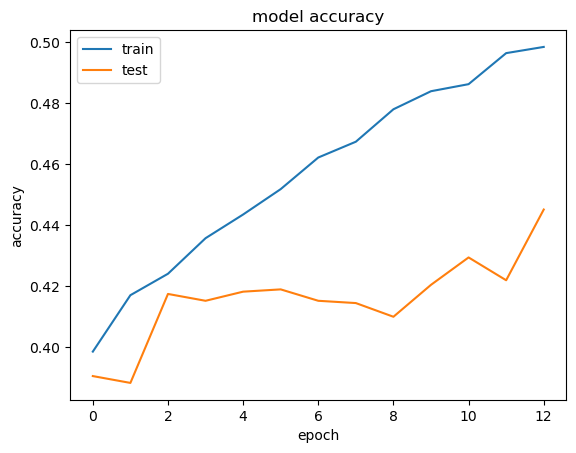

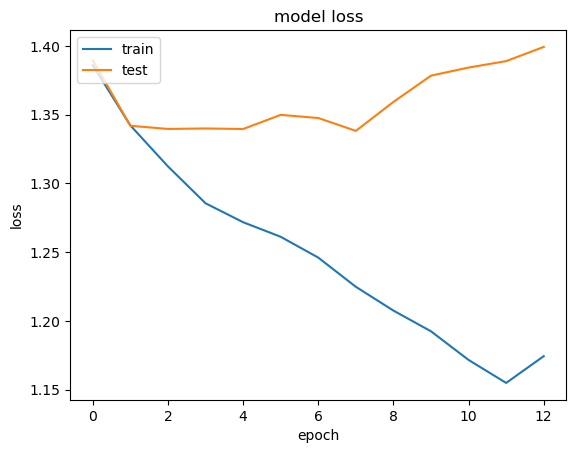

In [30]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
evaluation_train = stock_price_predictior.evaluate(X_train_scaled, np.array(y_train))
evaluation_val = stock_price_predictior.evaluate(X_val_scaled, np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(X_test_scaled, np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 4ms/step - loss: 1.4538 - categorical_accuracy: 0.4207

loss on training set: 1.0775121450424194
accuracy on training set: 0.5321864485740662

loss on validation set: 1.3993432521820068
accuracy on validation set: 0.4450261890888214

loss on test set: 1.453782081604004
accuracy on test set: 0.4207407534122467


In [32]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, 'relu', 'relu')
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [33]:
scaler = utilities.StandardScaler3D()
X_train_new_scaled = scaler.fit_transform(np.array(X_train_new))
X_val_scaled = utilities.apply3DScaler(np.array(X_val), scaler)
X_test_scaled = utilities.apply3DScaler(np.array(X_test), scaler)

In [34]:
history = stock_price_predictior.fit(X_train_new_scaled, np.array(y_train_new), X_val_scaled, np.array(y_val), add_early_stopping = True)

Epoch 1/500
1094/1094 [==============================] - 14s 12ms/step - loss: 1.4488 - categorical_accuracy: 0.3805 - val_loss: 1.4863 - val_categorical_accuracy: 0.3201
Epoch 2/500
1094/1094 [==============================] - 13s 11ms/step - loss: 1.3118 - categorical_accuracy: 0.4511 - val_loss: 1.4982 - val_categorical_accuracy: 0.3381
Epoch 3/500
1094/1094 [==============================] - 12s 11ms/step - loss: 1.1968 - categorical_accuracy: 0.4950 - val_loss: 1.5937 - val_categorical_accuracy: 0.3373
Epoch 4/500
1094/1094 [==============================] - 12s 11ms/step - loss: 1.1138 - categorical_accuracy: 0.5391 - val_loss: 1.6663 - val_categorical_accuracy: 0.3448
Epoch 5/500
1094/1094 [==============================] - 12s 11ms/step - loss: 1.0466 - categorical_accuracy: 0.5710 - val_loss: 1.8587 - val_categorical_accuracy: 0.3470
Epoch 6/500
1094/1094 [==============================] - 12s 11ms/step - loss: 0.9693 - categorical_accuracy: 0.6001 - val_loss: 1.8588 - val_cat

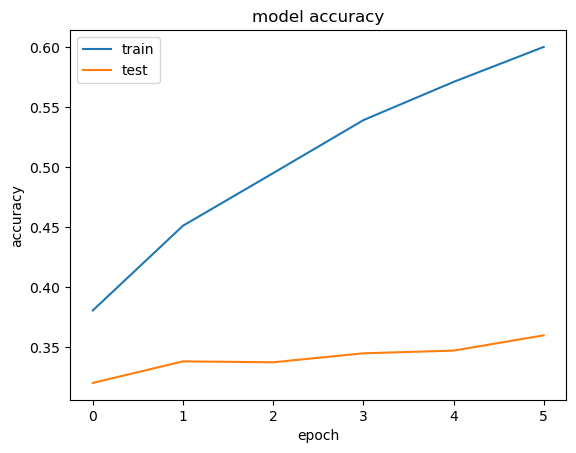

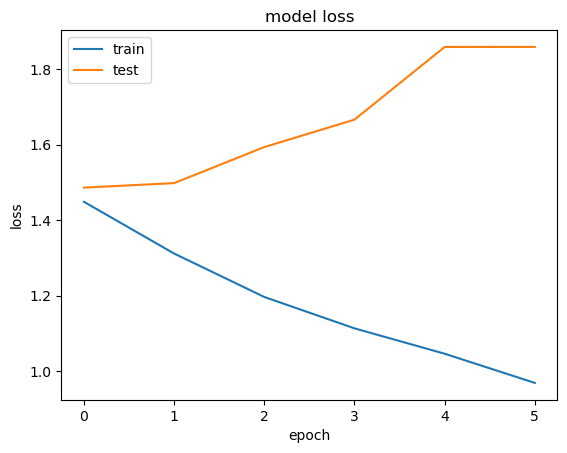

In [35]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
evaluation_train = stock_price_predictior.evaluate(X_train_new_scaled, np.array(y_train_new))
evaluation_val = stock_price_predictior.evaluate(X_val_scaled, np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(X_test_scaled, np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 4ms/step - loss: 1.9151 - categorical_accuracy: 0.3422

loss on training set: 0.8624855279922485
accuracy on training set: 0.6432856917381287

loss on validation set: 1.8588026762008667
accuracy on validation set: 0.35976067185401917

loss on test set: 1.915082335472107
accuracy on test set: 0.3422222137451172


# Experiment 4
lstm layer size - 256
<br>
dense layer size - 256
<br>
activation function - leaky_relu
<br>
optimizer - adam with 0.01 learning rate
<br>
loss - CategoricalCrossEntropy
<br>
acurracy - Categorical Accuracy

In [37]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, 'leaky_relu', 'leaky_relu')
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [38]:
scaler = utilities.StandardScaler3D()
X_train_scaled = scaler.fit_transform(np.array(X_train))
X_val_scaled = utilities.apply3DScaler(np.array(X_val), scaler)
X_test_scaled = utilities.apply3DScaler(np.array(X_test), scaler)

In [39]:
history = stock_price_predictior.fit(X_train_scaled, np.array(y_train), X_val_scaled, np.array(y_val), add_early_stopping = True)

Epoch 1/500
338/338 [==============================] - 6s 13ms/step - loss: 1.3904 - categorical_accuracy: 0.3964 - val_loss: 1.3434 - val_categorical_accuracy: 0.4099
Epoch 2/500
338/338 [==============================] - 4s 11ms/step - loss: 1.3295 - categorical_accuracy: 0.4177 - val_loss: 1.3407 - val_categorical_accuracy: 0.3994
Epoch 3/500
338/338 [==============================] - 4s 12ms/step - loss: 1.3238 - categorical_accuracy: 0.4270 - val_loss: 1.3372 - val_categorical_accuracy: 0.4174
Epoch 4/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2948 - categorical_accuracy: 0.4413 - val_loss: 1.3271 - val_categorical_accuracy: 0.4061
Epoch 5/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2743 - categorical_accuracy: 0.4450 - val_loss: 1.3409 - val_categorical_accuracy: 0.4031
Epoch 6/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2625 - categorical_accuracy: 0.4501 - val_loss: 1.3450 - val_categorical_accuracy:

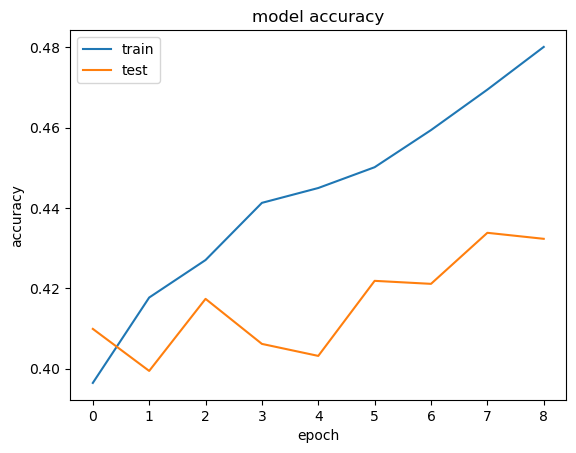

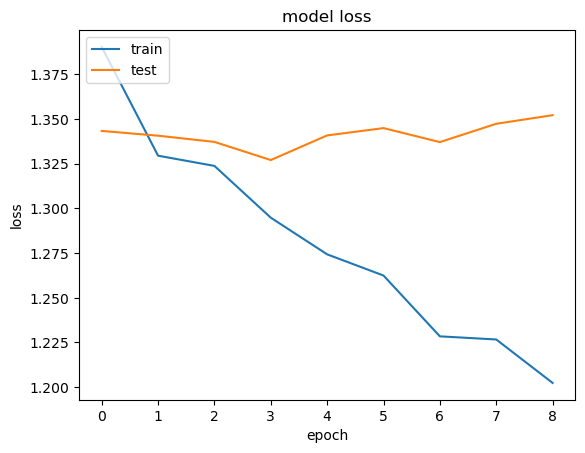

In [40]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
evaluation_train = stock_price_predictior.evaluate(X_train_scaled, np.array(y_train))
evaluation_val = stock_price_predictior.evaluate(X_val_scaled, np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(X_test_scaled, np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 4ms/step - loss: 1.3849 - categorical_accuracy: 0.4148

loss on training set: 1.1461163759231567
accuracy on training set: 0.5063818097114563

loss on validation set: 1.3521971702575684
accuracy on validation set: 0.43231114745140076

loss on test set: 1.3849481344223022
accuracy on test set: 0.4148148000240326


# Experiment 5
lstm layer size - 256
<br>
dense layer size - 256
<br>
activation function LSTM - tanh
<br>
activation function dense - relu
<br>
optimizer - adam with 0.01 learning rate
<br>
loss - CategoricalCrossEntropy
<br>
acurracy - Categorical Accuracy

In [42]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, "tanh", "relu")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = stock_price_predictior.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), add_early_stopping = False)

Epoch 1/500
338/338 [==============================] - 6s 12ms/step - loss: 1.3633 - categorical_accuracy: 0.4055 - val_loss: 1.3330 - val_categorical_accuracy: 0.4106
Epoch 2/500
338/338 [==============================] - 4s 11ms/step - loss: 1.3035 - categorical_accuracy: 0.4349 - val_loss: 1.3378 - val_categorical_accuracy: 0.3942
Epoch 3/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2772 - categorical_accuracy: 0.4455 - val_loss: 1.3301 - val_categorical_accuracy: 0.4046
Epoch 4/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2555 - categorical_accuracy: 0.4605 - val_loss: 1.3207 - val_categorical_accuracy: 0.4331
Epoch 5/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2319 - categorical_accuracy: 0.4708 - val_loss: 1.3265 - val_categorical_accuracy: 0.4181
Epoch 6/500
338/338 [==============================] - 4s 10ms/step - loss: 1.2120 - categorical_accuracy: 0.4868 - val_loss: 1.3394 - val_categorical_accuracy:

338/338 [==============================] - 4s 10ms/step - loss: 0.5824 - categorical_accuracy: 0.7639 - val_loss: 2.0432 - val_categorical_accuracy: 0.3897
Epoch 98/500
338/338 [==============================] - 4s 10ms/step - loss: 0.5916 - categorical_accuracy: 0.7622 - val_loss: 2.0423 - val_categorical_accuracy: 0.3889
Epoch 99/500
338/338 [==============================] - 4s 10ms/step - loss: 0.5907 - categorical_accuracy: 0.7619 - val_loss: 2.0559 - val_categorical_accuracy: 0.3897
Epoch 100/500
338/338 [==============================] - 4s 10ms/step - loss: 0.5682 - categorical_accuracy: 0.7687 - val_loss: 2.0806 - val_categorical_accuracy: 0.3934
Epoch 101/500
338/338 [==============================] - 4s 10ms/step - loss: 0.5760 - categorical_accuracy: 0.7675 - val_loss: 2.0983 - val_categorical_accuracy: 0.3852
Epoch 102/500
338/338 [==============================] - 4s 10ms/step - loss: 0.5753 - categorical_accuracy: 0.7702 - val_loss: 2.0431 - val_categorical_accuracy: 0.3

338/338 [==============================] - 3s 10ms/step - loss: 0.5045 - categorical_accuracy: 0.8021 - val_loss: 2.3761 - val_categorical_accuracy: 0.3822
Epoch 194/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4973 - categorical_accuracy: 0.8020 - val_loss: 2.3974 - val_categorical_accuracy: 0.3740
Epoch 195/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4886 - categorical_accuracy: 0.8023 - val_loss: 2.3775 - val_categorical_accuracy: 0.3815
Epoch 196/500
338/338 [==============================] - 4s 12ms/step - loss: 0.5004 - categorical_accuracy: 0.7989 - val_loss: 2.3760 - val_categorical_accuracy: 0.3867
Epoch 197/500
338/338 [==============================] - 4s 12ms/step - loss: 0.4995 - categorical_accuracy: 0.8000 - val_loss: 2.4200 - val_categorical_accuracy: 0.3927
Epoch 198/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4968 - categorical_accuracy: 0.8021 - val_loss: 2.4207 - val_categorical_accuracy: 0

338/338 [==============================] - 4s 11ms/step - loss: 0.4646 - categorical_accuracy: 0.8164 - val_loss: 2.5326 - val_categorical_accuracy: 0.3934
Epoch 290/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4535 - categorical_accuracy: 0.8231 - val_loss: 2.5174 - val_categorical_accuracy: 0.3867
Epoch 291/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4678 - categorical_accuracy: 0.8168 - val_loss: 2.5203 - val_categorical_accuracy: 0.3837
Epoch 292/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4596 - categorical_accuracy: 0.8198 - val_loss: 2.5455 - val_categorical_accuracy: 0.3852
Epoch 293/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4650 - categorical_accuracy: 0.8151 - val_loss: 2.5425 - val_categorical_accuracy: 0.4069
Epoch 294/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4583 - categorical_accuracy: 0.8212 - val_loss: 2.5404 - val_categorical_accuracy: 0

338/338 [==============================] - 4s 11ms/step - loss: 0.4356 - categorical_accuracy: 0.8310 - val_loss: 2.6415 - val_categorical_accuracy: 0.3829
Epoch 386/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4399 - categorical_accuracy: 0.8272 - val_loss: 2.6434 - val_categorical_accuracy: 0.3904
Epoch 387/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4358 - categorical_accuracy: 0.8344 - val_loss: 2.6463 - val_categorical_accuracy: 0.3844
Epoch 388/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4415 - categorical_accuracy: 0.8282 - val_loss: 2.6522 - val_categorical_accuracy: 0.3852
Epoch 389/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4464 - categorical_accuracy: 0.8255 - val_loss: 2.6621 - val_categorical_accuracy: 0.4016
Epoch 390/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4382 - categorical_accuracy: 0.8279 - val_loss: 2.6993 - val_categorical_accuracy: 0

338/338 [==============================] - 4s 11ms/step - loss: 0.4366 - categorical_accuracy: 0.8307 - val_loss: 2.6273 - val_categorical_accuracy: 0.4091
Epoch 482/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4189 - categorical_accuracy: 0.8374 - val_loss: 2.6177 - val_categorical_accuracy: 0.3897
Epoch 483/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4200 - categorical_accuracy: 0.8336 - val_loss: 2.6326 - val_categorical_accuracy: 0.3957
Epoch 484/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4253 - categorical_accuracy: 0.8336 - val_loss: 2.6246 - val_categorical_accuracy: 0.4076
Epoch 485/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4185 - categorical_accuracy: 0.8414 - val_loss: 2.6525 - val_categorical_accuracy: 0.4024
Epoch 486/500
338/338 [==============================] - 4s 11ms/step - loss: 0.4207 - categorical_accuracy: 0.8334 - val_loss: 2.6845 - val_categorical_accuracy: 0

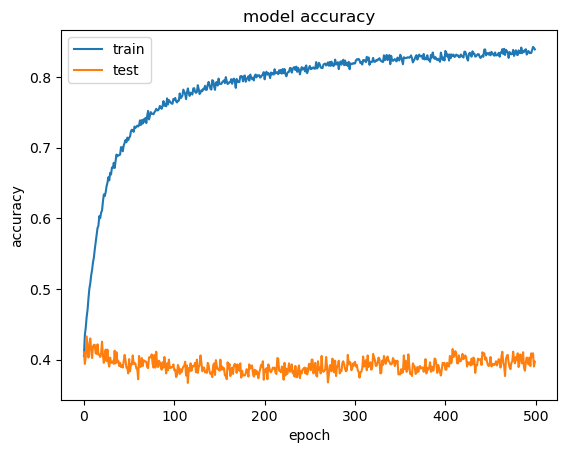

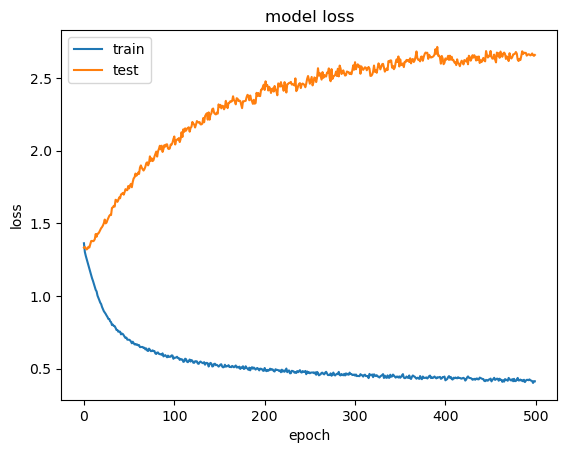

In [44]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
evaluation_train = stock_price_predictior.evaluate(np.array(X_train), np.array(y_train))
evaluation_val = stock_price_predictior.evaluate(np.array(X_val), np.array(y_val))
evaluation_test = stock_price_predictior.evaluate(np.array(X_test), np.array(y_test))
utilities.print_evaluation(evaluation_train, evaluation_test, evaluation_val)

43/43 [==============================] - 0s 4ms/step - loss: 2.9383 - categorical_accuracy: 0.3889

loss on training set: 0.17856477200984955
accuracy on training set: 0.9516278505325317

loss on validation set: 2.6592016220092773
accuracy on validation set: 0.39715781807899475

loss on test set: 2.9382834434509277
accuracy on test set: 0.3888888955116272


In [46]:
scaler = utilities.StandardScaler3D()
X_train_scaled = scaler.fit_transform(np.array(X_train))
X_val_scaled = utilities.apply3DScaler(np.array(X_val), scaler)
X_test_scaled = utilities.apply3DScaler(np.array(X_test), scaler)

In [47]:
history = stock_price_predictior.fit(X_train_scaled, np.array(y_train), X_val_scaled, np.array(y_val), add_early_stopping = False)

Epoch 1/500
338/338 [==============================] - 4s 12ms/step - loss: 2.2469 - categorical_accuracy: 0.3516 - val_loss: 1.5667 - val_categorical_accuracy: 0.3560
Epoch 2/500
338/338 [==============================] - 4s 12ms/step - loss: 1.5396 - categorical_accuracy: 0.3719 - val_loss: 1.5082 - val_categorical_accuracy: 0.3605
Epoch 3/500
338/338 [==============================] - 4s 12ms/step - loss: 1.4630 - categorical_accuracy: 0.3805 - val_loss: 1.4639 - val_categorical_accuracy: 0.3815
Epoch 4/500
338/338 [==============================] - 4s 12ms/step - loss: 1.4411 - categorical_accuracy: 0.3902 - val_loss: 1.4478 - val_categorical_accuracy: 0.3949
Epoch 5/500
338/338 [==============================] - 4s 12ms/step - loss: 1.4101 - categorical_accuracy: 0.3958 - val_loss: 1.3573 - val_categorical_accuracy: 0.3987
Epoch 6/500
338/338 [==============================] - 4s 12ms/step - loss: 1.4018 - categorical_accuracy: 0.3991 - val_loss: 1.3932 - val_categorical_accuracy:

KeyboardInterrupt: 

# Experiment 6
lstm layer size - 256
<br>
dense layer size - 256
<br>
activation function LSTM - tanh
<br>
activation function dense - relu
<br>
regularization LSTM - L1
<br>
optimizer - adam with 0.01 learning rate
<br>
loss - CategoricalCrossEntropy
<br>
acurracy - Categorical Accuracy

In [48]:
stock_price_predictior = stockPredictorModule.stockPricePredictor(len(X_train[0]), len(X_train[0][0]), 256, 256, "tanh", "relu", "L1")
stock_price_predictior.compile()
stock_price_predictior.model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               376832    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 443,909
Trainable params: 443,909
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = stock_price_predictior.fit(X_train_scaled, np.array(y_train), X_val_scaled, np.array(y_val), add_early_stopping = False)

Epoch 1/500
338/338 [==============================] - 4s 11ms/step - loss: 1.3761 - categorical_accuracy: 0.3979 - val_loss: 1.4408 - val_categorical_accuracy: 0.3530
Epoch 2/500
338/338 [==============================] - 4s 11ms/step - loss: 1.3337 - categorical_accuracy: 0.4146 - val_loss: 1.4370 - val_categorical_accuracy: 0.3687
Epoch 3/500
338/338 [==============================] - 4s 11ms/step - loss: 1.3152 - categorical_accuracy: 0.4292 - val_loss: 1.4590 - val_categorical_accuracy: 0.3463
Epoch 4/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2984 - categorical_accuracy: 0.4313 - val_loss: 1.4429 - val_categorical_accuracy: 0.3493
Epoch 5/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2827 - categorical_accuracy: 0.4410 - val_loss: 1.4869 - val_categorical_accuracy: 0.3455
Epoch 6/500
338/338 [==============================] - 4s 11ms/step - loss: 1.2651 - categorical_accuracy: 0.4565 - val_loss: 1.4916 - val_categorical_accuracy:

338/338 [==============================] - 4s 11ms/step - loss: 0.3249 - categorical_accuracy: 0.8877 - val_loss: 6.5072 - val_categorical_accuracy: 0.2984
Epoch 98/500
338/338 [==============================] - 4s 11ms/step - loss: 0.3330 - categorical_accuracy: 0.8886 - val_loss: 6.1824 - val_categorical_accuracy: 0.3231
Epoch 99/500
338/338 [==============================] - 4s 11ms/step - loss: 0.3276 - categorical_accuracy: 0.8872 - val_loss: 8.6133 - val_categorical_accuracy: 0.3269
Epoch 100/500
338/338 [==============================] - 4s 11ms/step - loss: 0.3198 - categorical_accuracy: 0.8933 - val_loss: 6.9526 - val_categorical_accuracy: 0.3119
Epoch 101/500
338/338 [==============================] - 4s 12ms/step - loss: 0.3300 - categorical_accuracy: 0.8898 - val_loss: 6.9657 - val_categorical_accuracy: 0.3224
Epoch 102/500
338/338 [==============================] - 4s 11ms/step - loss: 0.3126 - categorical_accuracy: 0.8954 - val_loss: 6.1970 - val_categorical_accuracy: 0.2

338/338 [==============================] - 4s 11ms/step - loss: 0.1947 - categorical_accuracy: 0.9554 - val_loss: 8.9252 - val_categorical_accuracy: 0.3089
Epoch 194/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1830 - categorical_accuracy: 0.9557 - val_loss: 10.7280 - val_categorical_accuracy: 0.3052
Epoch 195/500
338/338 [==============================] - 4s 11ms/step - loss: 0.1784 - categorical_accuracy: 0.9605 - val_loss: 10.8782 - val_categorical_accuracy: 0.2947
Epoch 196/500
338/338 [==============================] - 4s 11ms/step - loss: 0.1805 - categorical_accuracy: 0.9562 - val_loss: 7.2935 - val_categorical_accuracy: 0.3149
Epoch 197/500
338/338 [==============================] - 4s 11ms/step - loss: 0.1862 - categorical_accuracy: 0.9546 - val_loss: 6.8078 - val_categorical_accuracy: 0.2902
Epoch 198/500
338/338 [==============================] - 4s 11ms/step - loss: 0.1937 - categorical_accuracy: 0.9521 - val_loss: 8.0377 - val_categorical_accuracy:

338/338 [==============================] - 4s 12ms/step - loss: 0.1378 - categorical_accuracy: 0.9757 - val_loss: 10.3598 - val_categorical_accuracy: 0.3254
Epoch 290/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1381 - categorical_accuracy: 0.9760 - val_loss: 7.9673 - val_categorical_accuracy: 0.3096
Epoch 291/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1510 - categorical_accuracy: 0.9737 - val_loss: 11.0505 - val_categorical_accuracy: 0.3269
Epoch 292/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1560 - categorical_accuracy: 0.9717 - val_loss: 11.1665 - val_categorical_accuracy: 0.2438
Epoch 293/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1687 - categorical_accuracy: 0.9685 - val_loss: 7.5575 - val_categorical_accuracy: 0.3321
Epoch 294/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1479 - categorical_accuracy: 0.9753 - val_loss: 6.8514 - val_categorical_accuracy

338/338 [==============================] - 4s 12ms/step - loss: 0.1301 - categorical_accuracy: 0.9809 - val_loss: 10.2390 - val_categorical_accuracy: 0.3037
Epoch 338/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1409 - categorical_accuracy: 0.9785 - val_loss: 12.6408 - val_categorical_accuracy: 0.3239
Epoch 339/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1316 - categorical_accuracy: 0.9809 - val_loss: 10.3366 - val_categorical_accuracy: 0.2969
Epoch 340/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1475 - categorical_accuracy: 0.9752 - val_loss: 9.4385 - val_categorical_accuracy: 0.3239
Epoch 341/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1459 - categorical_accuracy: 0.9738 - val_loss: 10.4879 - val_categorical_accuracy: 0.3171
Epoch 342/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1459 - categorical_accuracy: 0.9770 - val_loss: 8.8994 - val_categorical_accurac

338/338 [==============================] - 4s 12ms/step - loss: 0.1312 - categorical_accuracy: 0.9797 - val_loss: 14.0888 - val_categorical_accuracy: 0.3126
Epoch 386/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1323 - categorical_accuracy: 0.9809 - val_loss: 14.0730 - val_categorical_accuracy: 0.3149
Epoch 387/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1452 - categorical_accuracy: 0.9784 - val_loss: 12.4951 - val_categorical_accuracy: 0.3194
Epoch 388/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1300 - categorical_accuracy: 0.9822 - val_loss: 11.6965 - val_categorical_accuracy: 0.3201
Epoch 389/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1177 - categorical_accuracy: 0.9847 - val_loss: 15.5742 - val_categorical_accuracy: 0.3179
Epoch 390/500
338/338 [==============================] - 4s 12ms/step - loss: 0.1138 - categorical_accuracy: 0.9864 - val_loss: 11.5831 - val_categorical_accur

KeyboardInterrupt: 